In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [35]:
dfPM10 = pd.read_csv('dane/PM10.csv', index_col=0, parse_dates=True)

In [36]:
dfPM10.isnull().sum().sort_values()

MpKrakAlKras    4010
MpKrakZloRog    4410
MpKrakDietla    4458
MpKrakBulwar    4843
MpKrakWadow     4866
MpKrakBujaka    5297
MpKrakSwoszo    5488
MpKrakOsPias    5511
MpKrakPrad      5525
MpKrakTelime    6802
dtype: int64

In [37]:
df = dfPM10[['MpKrakZloRog', 'MpKrakDietla', 'MpKrakWadow']]

In [38]:
print(df.MpKrakZloRog.first_valid_index())
print(df.MpKrakDietla.first_valid_index())
print(df.MpKrakWadow.first_valid_index())

2016-01-01 00:00:00
2016-01-01 00:00:00
2017-02-03 00:00:00


In [39]:
dfZR = dfPM10.MpKrakZloRog
dfZR = dfZR.loc[df.MpKrakZloRog.first_valid_index():]
dfZR

data
2016-01-01    184.00
2016-01-02     49.00
2016-01-03     56.00
2016-01-04     92.00
2016-01-05    133.00
               ...  
2023-12-27     22.75
2023-12-28     41.58
2023-12-29     20.02
2023-12-30     12.88
2023-12-31     27.16
Name: MpKrakZloRog, Length: 2922, dtype: float64

In [40]:
dfZR.isnull().sum()

np.int64(27)

In [41]:
# filling missing data
rolling_mean = dfZR.rolling(window=3, min_periods=1).mean()
rolling_mean

data
2016-01-01    184.000000
2016-01-02    116.500000
2016-01-03     96.333333
2016-01-04     65.666667
2016-01-05     93.666667
                 ...    
2023-12-27     12.293333
2023-12-28     24.023333
2023-12-29     28.116667
2023-12-30     24.826667
2023-12-31     20.020000
Name: MpKrakZloRog, Length: 2922, dtype: float64

In [42]:
dfZR.fillna(rolling_mean, inplace=True)

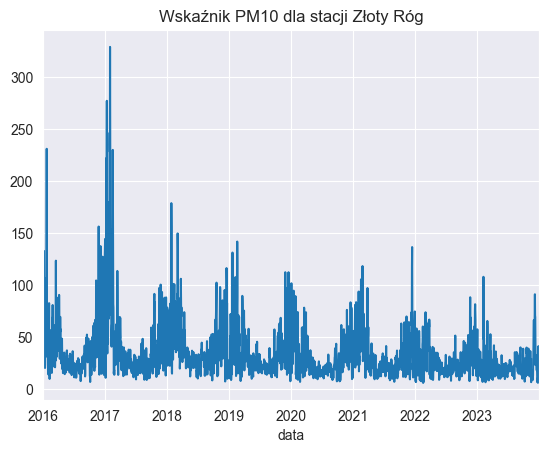

In [43]:
dfZR.plot()
plt.title('Wskaźnik PM10 dla stacji Złoty Róg')
plt.show()

In [44]:
dfZR.describe()

count    2922.000000
mean       34.409218
std        25.877496
min         6.250000
25%        19.030000
50%        27.190000
75%        40.537500
max       329.100000
Name: MpKrakZloRog, dtype: float64

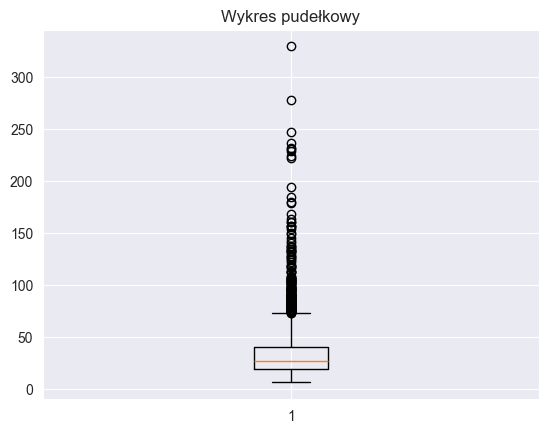

In [45]:
plt.boxplot(dfZR)
plt.title('Wykres pudełkowy')
plt.show()

In [46]:
Q1 = dfZR.quantile(0.25)
Q3 = dfZR.quantile(0.75)
IQR = Q3 - Q1

In [47]:
Q1 - 1.5 * IQR
# not existing value

np.float64(-13.231250000000003)

In [48]:
(dfZR > Q3 + 1.5 * IQR).sum()

np.int64(206)

In [49]:
outliers = dfZR[(dfZR > Q3 + 1.5 * IQR)]
outliers

data
2016-01-01    184.00
2016-01-04     92.00
2016-01-05    133.00
2016-01-06    133.00
2016-01-07    133.00
               ...  
2022-12-20     81.84
2022-12-21     72.95
2023-02-07    108.20
2023-12-06     78.54
2023-12-07     91.42
Name: MpKrakZloRog, Length: 206, dtype: float64

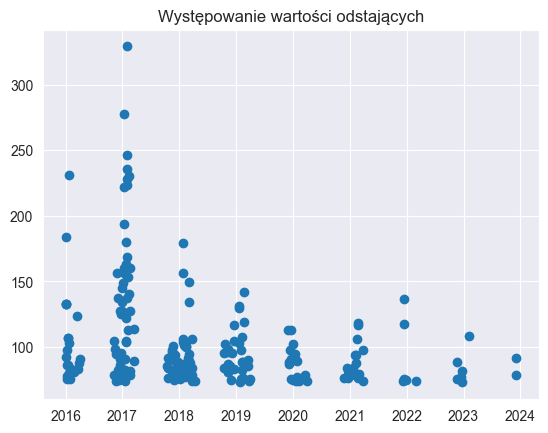

In [50]:
plt.scatter(x=outliers.index, y=outliers.values)
plt.title('Występowanie wartości odstających')
plt.show()
# probably not error, just extreme values
# 10 biggest to max

In [51]:
outliers.groupby(outliers.index.month).count()

data
1     61
2     43
3     26
4      2
10     7
11    25
12    42
Name: MpKrakZloRog, dtype: int64

In [52]:
outliers.sort_values(ascending=False, inplace=True)
max10 = outliers.iloc[10]

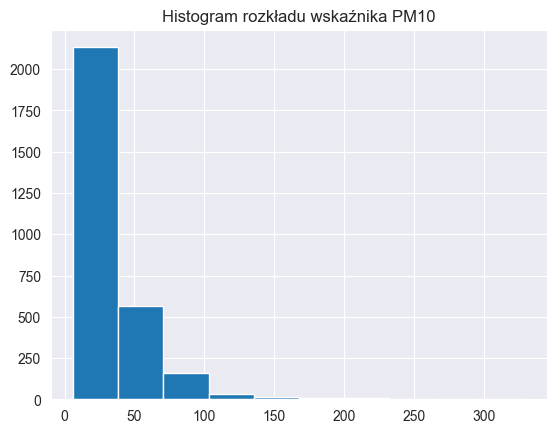

In [53]:
plt.hist(dfZR)
plt.title('Histogram rozkładu wskaźnika PM10')
plt.show()

In [54]:
# adding new features
dfZR = dfZR.to_frame()
# consider one-hot encoding
dfZR['miesiac'] = dfZR.index.month
dfZR['dzien_tygodnia'] = dfZR.index.dayofweek + 1    # index starts at 0 
# no dependance
#dfZR['dzien'] = dfZR.index.day 
dfZR['rok'] = dfZR.index.year

In [55]:
day_off_idx = dfZR.loc[(dfZR['dzien_tygodnia'] == 6) | (dfZR['dzien_tygodnia'] == 7)].index
dfZR['dzien_wolny'] = 0
dfZR.loc[day_off_idx, 'dzien_wolny'] = 1

In [56]:
from datetime import date, timedelta
import holidays

In [72]:
#pl_holidays = holidays.Poland() 
holidays_dates = []
years = range(2016, 2024) 
for ptr in holidays.Poland(years = years).items(): 
    #print(ptr[0]) 
    holidays_dates.append(ptr[0])

In [77]:
dfZR.loc[holidays_dates, 'dzien_wolny'] = 1

In [78]:
# sin-cos instead of one-hot encoding
dfZR['miesiac_sin'] = np.sin(2 * np.pi * dfZR['miesiac'] / 12)
dfZR['miesiac_cos'] = np.cos(2 * np.pi * dfZR['miesiac'] / 12)

In [79]:
# rolling means
dfZR['pm10_7d_avg'] = dfZR['MpKrakZloRog'].rolling(window=7).mean()
dfZR['pm10_30d_avg'] = dfZR['MpKrakZloRog'].rolling(window=30).mean()

In [80]:
# lags
for lag in range(1, 8):
    dfZR[f'lag_{lag}'] = dfZR['MpKrakZloRog'].shift(lag)


In [81]:
dfZR.isnull().sum()
# rolling mean caused missing values in 29 first days
# not much, can be omitted 

MpKrakZloRog       0
miesiac            0
dzien_tygodnia     0
rok                0
dzien_wolny        0
miesiac_sin        0
miesiac_cos        0
pm10_7d_avg        6
pm10_30d_avg      29
lag_1              1
lag_2              2
lag_3              3
lag_4              4
lag_5              5
lag_6              6
lag_7              7
dtype: int64

In [82]:
#dfZR.interpolate(method='linear', inplace=True)
dfZR.dropna(inplace=True)

In [83]:
# statistical significantion

In [84]:
# month - statistically significant, but in sin/cos form
# dayofweek - rather not significant
# day_off - may be significant
# year - there is a trend
# averages/lags

In [85]:
dfZR

,MpKrakZloRog,miesiac,dzien_tygodnia,rok,dzien_wolny,miesiac_sin,miesiac_cos,pm10_7d_avg,pm10_30d_avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
data,,,,,,,,,,,,,,,,
2016-01-30,24.20,1,6,2016,1,5.000000e-01,0.866025,53.757143,81.823333,75.40,31.00,49.10,55.30,61.50,79.80,231.20
2016-01-31,19.20,1,7,2016,1,5.000000e-01,0.866025,45.100000,76.330000,24.20,75.40,31.00,49.10,55.30,61.50,79.80
2016-02-01,36.10,2,1,2016,0,8.660254e-01,0.500000,41.471429,75.900000,19.20,24.20,75.40,31.00,49.10,55.30,61.50
2016-02-02,14.40,2,2,2016,0,8.660254e-01,0.500000,35.628571,74.513333,36.10,19.20,24.20,75.40,31.00,49.10,55.30
2016-02-03,29.20,2,3,2016,0,8.660254e-01,0.500000,32.785714,72.420000,14.40,36.10,19.20,24.20,75.40,31.00,49.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,22.75,12,3,2023,0,-2.449294e-16,1.000000,10.431429,34.006667,7.74,6.39,8.54,10.11,10.44,7.05,15.12
2023-12-28,41.58,12,4,2023,0,-2.449294e-16,1.000000,15.364286,34.396333,22.75,7.74,6.39,8.54,10.11,10.44,7.05
2023-12-29,20.02,12,5,2023,0,-2.449294e-16,1.000000,16.732857,33.606333,41.58,22.75,7.74,6.39,8.54,10.11,10.44


In [86]:
# weather data
weather = pd.read_csv('pogoda16-23.csv', sep=';', index_col=0, parse_dates=True)
weather.drop(columns=['averagePm10'], inplace=True)
for col in weather.columns:
    rolling_mean = weather[col].rolling(window=7, min_periods=1).mean()
    weather[col] = weather[col].fillna(rolling_mean)
weather.index = weather.index.normalize() 
weather.index = weather.index.rename('data')
weather

,averageAirTemp,averageAirPressure,averageWindDirection,maxWindSpeed,averageWindSpeed,rainIntensity
data,,,,,,
2016-01-01,-10.315486,999.586389,76.000000,6.200,2.956319,0.0
2016-01-02,-13.073542,993.289792,73.000000,5.600,2.472778,0.0
2016-01-03,-11.246806,976.609861,57.000000,4.000,1.709444,0.0
2016-01-04,-6.664514,974.405694,71.000000,3.000,1.155556,0.0
2016-01-05,-2.247847,976.495556,43.000000,2.700,0.966319,0.0
...,...,...,...,...,...,...
2023-12-26,5.569878,989.180156,26.000000,3.900,0.849444,0.0
2023-12-27,5.875231,987.571968,225.166667,6.800,2.307141,0.0
2023-12-28,6.397812,986.247049,219.600000,6.280,1.844833,0.0


In [87]:
dfZR = pd.merge(dfZR, weather, on='data', how='inner')

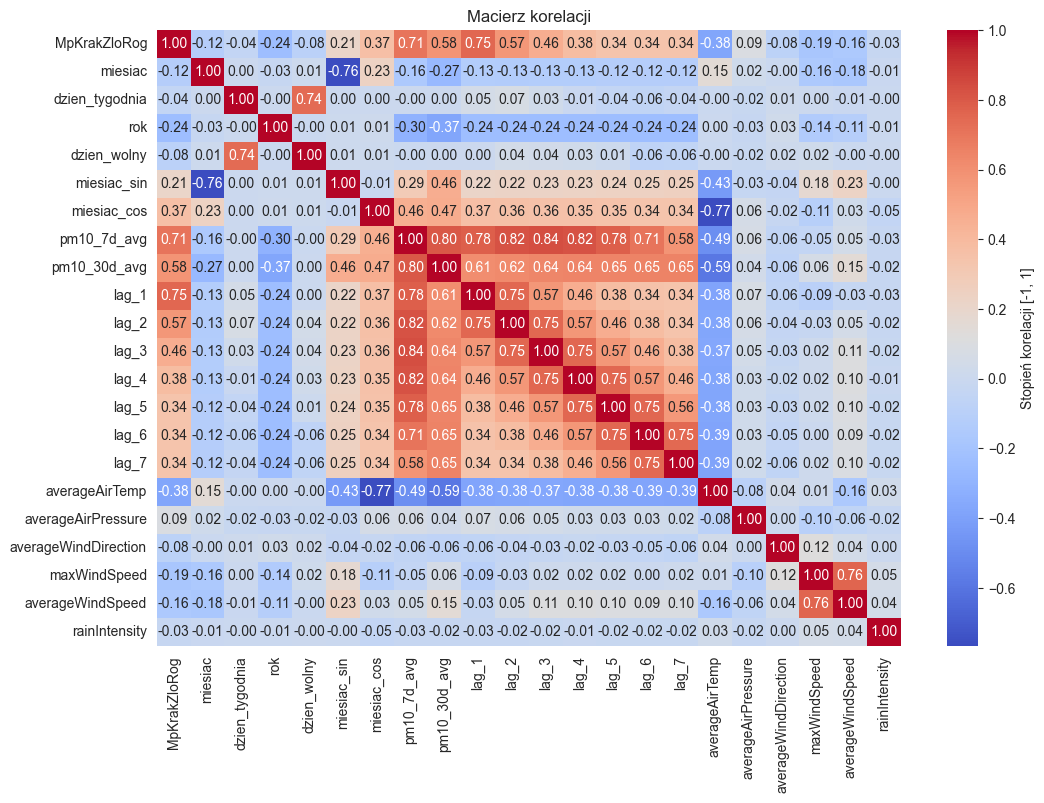

In [88]:
correlation = dfZR.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Stopień korelacji [-1, 1]'})

plt.title('Macierz korelacji')
plt.show()

# linear correlation between binary feature is usually low

In [89]:
from sklearn.model_selection import train_test_split

X = dfZR[dfZR.columns[~dfZR.columns.isin(['MpKrakZloRog','miesiac', 'dzien_tygodnia'])]]
y = dfZR['MpKrakZloRog']

# one year
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=44)

In [90]:
from sklearn.preprocessing import StandardScaler

# standarization

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# normalization
# outliers are problematic

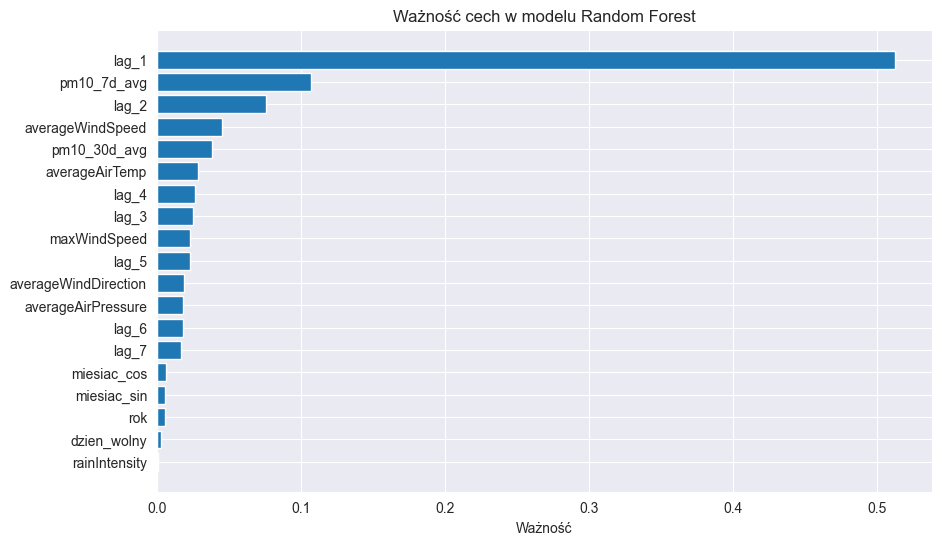

In [91]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=44)
rf_model.fit(X_train_scaled, y_train)

importances = rf_model.feature_importances_

indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.title("Ważność cech w modelu Random Forest")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel("Ważność")
plt.show()

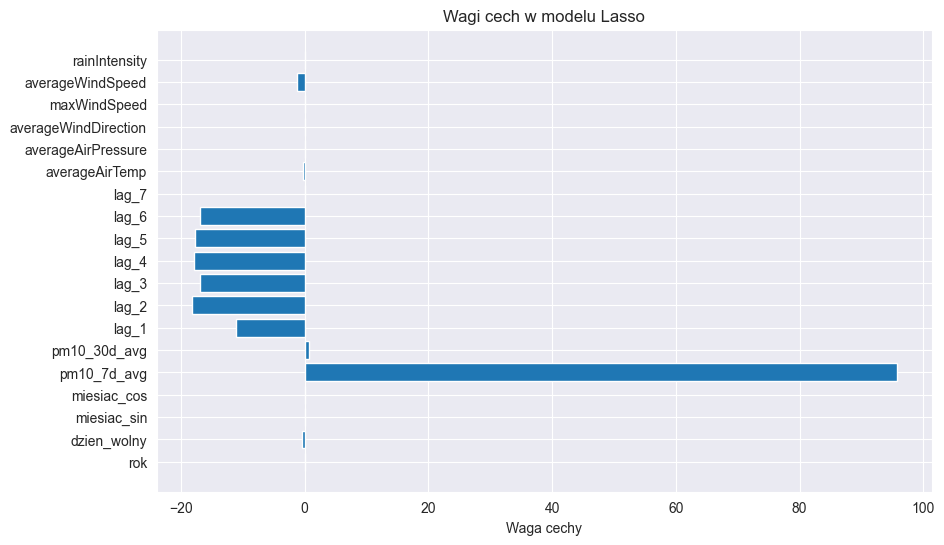

In [92]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.3) 

lasso.fit(X_train_scaled, y_train)

lasso_coef = lasso.coef_

plt.figure(figsize=(10, 6))
plt.title("Wagi cech w modelu Lasso")
plt.barh(X.columns, lasso_coef)
plt.xlabel("Waga cechy")
plt.show()

In [93]:
from scipy import stats
f_statistic, p_value = stats.f_oneway(*[dfZR[dfZR['miesiac'] == month]['MpKrakZloRog'] for month in range(1, 13)])

print(f"Test ANOVA - statystyka F: {f_statistic:.2f}, p-value: {p_value}")


Test ANOVA - statystyka F: 61.47, p-value: 3.422022333161402e-123


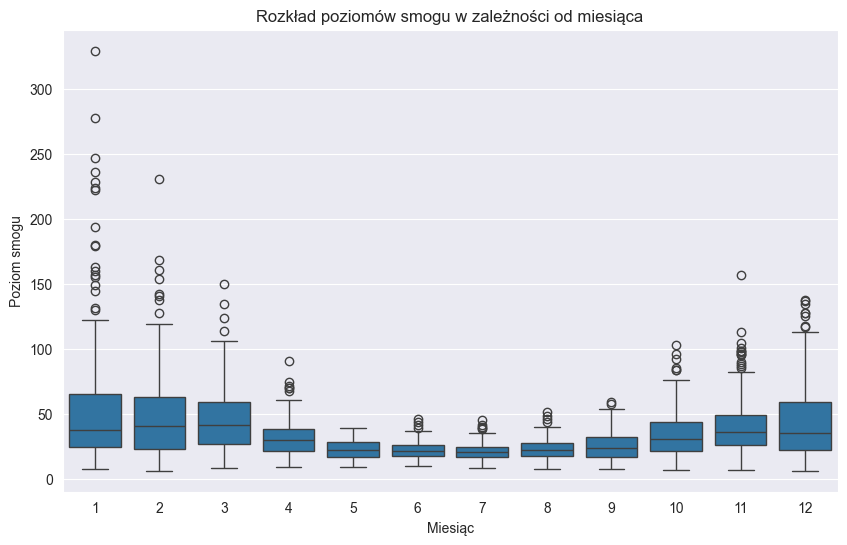

In [94]:
plt.figure(figsize=(10,6))
sns.boxplot(data=dfZR, x='miesiac', y='MpKrakZloRog')

plt.title('Rozkład poziomów smogu w zależności od miesiąca')
plt.xlabel('Miesiąc')
plt.ylabel('Poziom smogu')

plt.show()

In [95]:
f_statistic, p_value = stats.f_oneway(*[dfZR[dfZR['dzien_tygodnia'] == day]['MpKrakZloRog'] for day in range(1, 8)])

print(f"Test ANOVA - statystyka F: {f_statistic:.2f}, p-value: {p_value}")


Test ANOVA - statystyka F: 4.22, p-value: 0.00030841858179687


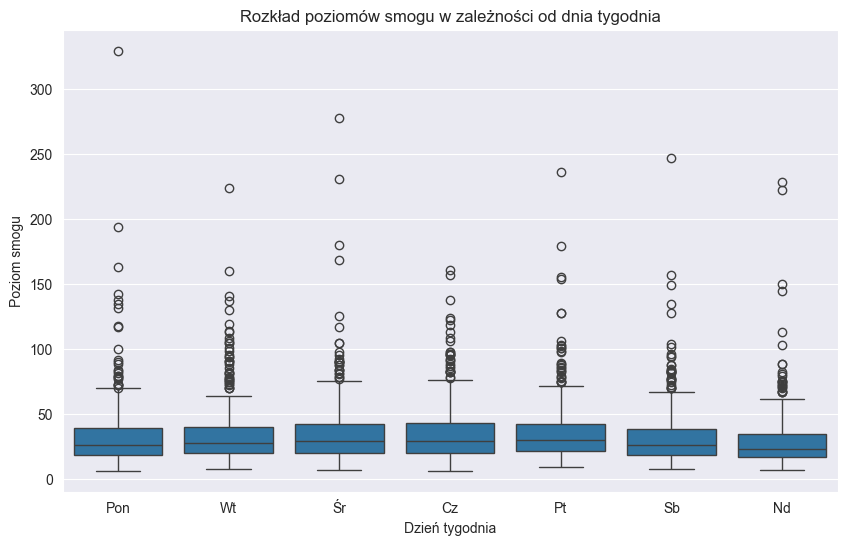

In [96]:
plt.figure(figsize=(10,6))
sns.boxplot(data=dfZR, x='dzien_tygodnia', y='MpKrakZloRog')

plt.title('Rozkład poziomów smogu w zależności od dnia tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('Poziom smogu')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Pon', 'Wt', 'Śr', 'Cz', 'Pt', 'Sb', 'Nd'])

plt.show()

In [97]:
print(f"Średni poziom smogu w dni robocze: {dfZR[dfZR['dzien_wolny'] == 1].MpKrakZloRog.mean():.2f}")
print(f"Średni poziom smogu w dni wolne: {dfZR[dfZR['dzien_wolny'] == 0].MpKrakZloRog.mean():.2f}")

Średni poziom smogu w dni robocze: 30.84
Średni poziom smogu w dni wolne: 35.46


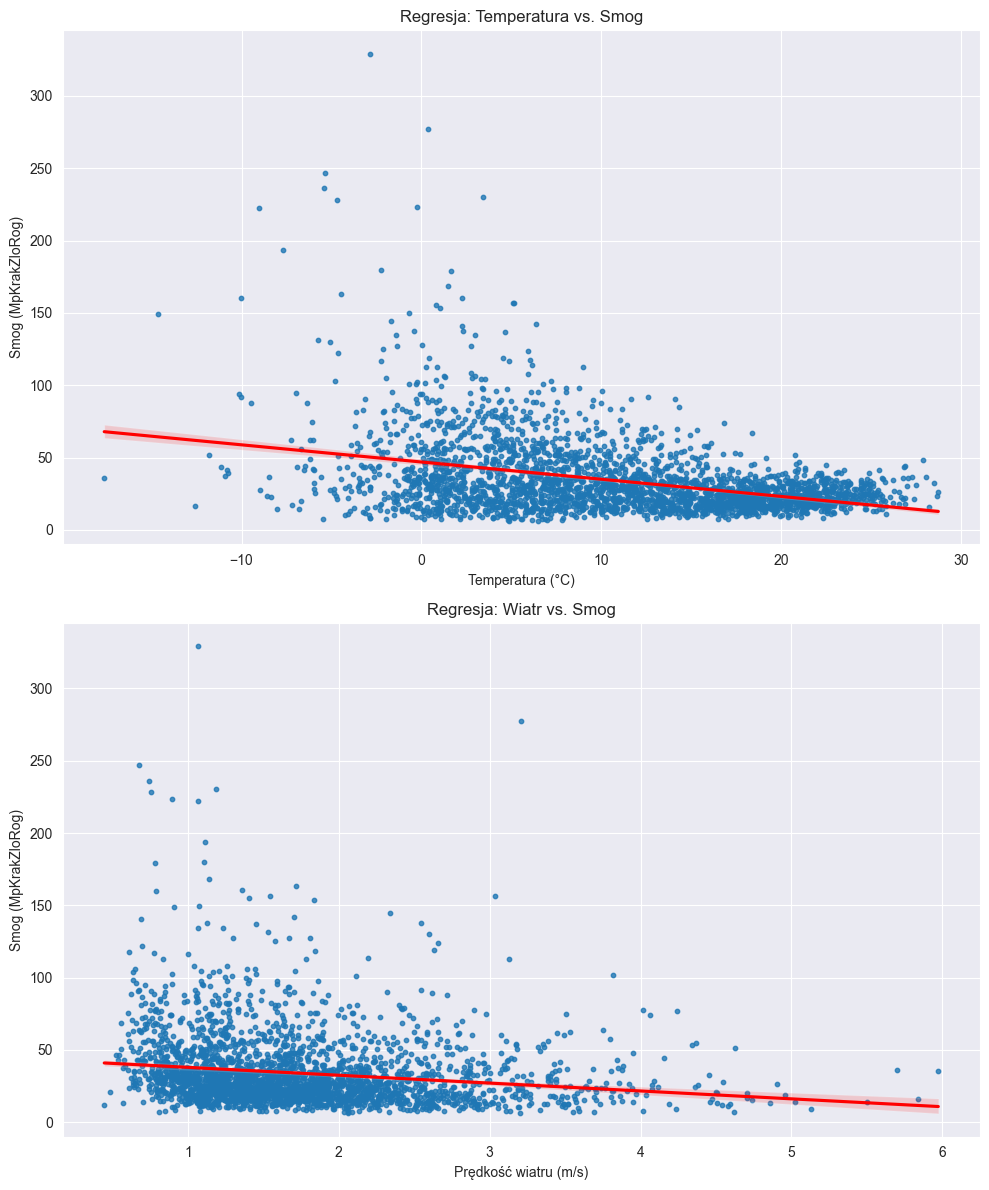

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 1, figsize=(10, 12)) 

sns.regplot(x=dfZR['averageAirTemp'], y=dfZR['MpKrakZloRog'], scatter_kws={'s':10}, line_kws={'color':'red'}, ax=axs[0])
axs[0].set_title('Regresja: Temperatura vs. Smog')
axs[0].set_xlabel('Temperatura (°C)')
axs[0].set_ylabel('Smog (MpKrakZloRog)')

sns.regplot(x=dfZR['averageWindSpeed'], y=dfZR['MpKrakZloRog'], scatter_kws={'s':10}, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_title('Regresja: Wiatr vs. Smog')
axs[1].set_xlabel('Prędkość wiatru (m/s)')
axs[1].set_ylabel('Smog (MpKrakZloRog)')

plt.tight_layout()
plt.show()

# the highest pollution =/= the lowest temperature

In [99]:
# stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(dfZR['MpKrakZloRog'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
# data are stationary

ADF Statistic: -4.842550980696561
p-value: 4.505900903644673e-05


In [100]:
dfZR

,MpKrakZloRog,miesiac,dzien_tygodnia,rok,dzien_wolny,miesiac_sin,miesiac_cos,pm10_7d_avg,pm10_30d_avg,lag_1,...,lag_4,lag_5,lag_6,lag_7,averageAirTemp,averageAirPressure,averageWindDirection,maxWindSpeed,averageWindSpeed,rainIntensity
data,,,,,,,,,,,,,,,,,,,,,
2016-01-30,24.20,1,6,2016,1,5.000000e-01,0.866025,53.757143,81.823333,75.40,...,55.30,61.50,79.80,231.20,4.877153,981.888611,257.000000,10.800,4.360486,0.0
2016-01-31,19.20,1,7,2016,1,5.000000e-01,0.866025,45.100000,76.330000,24.20,...,49.10,55.30,61.50,79.80,4.431111,986.740486,264.000000,6.500,1.905694,0.0
2016-02-01,36.10,2,1,2016,0,8.660254e-01,0.500000,41.471429,75.900000,19.20,...,31.00,49.10,55.30,61.50,11.222847,987.009583,249.000000,13.700,5.699236,0.0
2016-02-02,14.40,2,2,2016,0,8.660254e-01,0.500000,35.628571,74.513333,36.10,...,75.40,31.00,49.10,55.30,6.709236,985.848264,274.000000,7.000,2.720556,0.0
2016-02-03,29.20,2,3,2016,0,8.660254e-01,0.500000,32.785714,72.420000,14.40,...,24.20,75.40,31.00,49.10,2.830833,989.548681,266.000000,9.200,2.865000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,7.74,12,2,2023,1,-2.449294e-16,1.000000,9.341429,34.233667,6.39,...,10.44,7.05,15.12,26.17,5.569878,989.180156,26.000000,3.900,0.849444,0.0
2023-12-27,22.75,12,3,2023,0,-2.449294e-16,1.000000,10.431429,34.006667,7.74,...,10.11,10.44,7.05,15.12,5.875231,987.571968,225.166667,6.800,2.307141,0.0
2023-12-28,41.58,12,4,2023,0,-2.449294e-16,1.000000,15.364286,34.396333,22.75,...,8.54,10.11,10.44,7.05,6.397812,986.247049,219.600000,6.280,1.844833,0.0


In [101]:
df = dfZR.copy()
df.drop(columns=['dzien_tygodnia', 'rainIntensity'], inplace=True)

In [102]:
df.to_csv('test.csv')